#Introduction
In this project, I am developing a robust deep learning pipeline using TensorFlow and EfficientNet to classify skin lesions from medical images. Using a dataset of 10,000 high-resolution skin images, I am continuously training and validating the model, refining its performance to handle large-scale data and build scalable machine learning solutions. By leveraging data augmentation, balanced class weighting, and transfer learning, this model is designed to assist in the early detection of skin cancer and encourage timely consultations with healthcare professionals.

This ongoing work demonstrates my ability to design and implement real-world, end-to-end machine learning solutions that aim to make a meaningful impact in healthcare. As the project progresses, I am optimizing the model further and exploring new techniques to enhance its accuracy and reliability.


 Import necessary libraries and modules

In [ ]:
import os
import shutil
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras.preprocessing.image import load_img, img_to_array


Combine the two image folders (part 1 and part 2) into a single directory

In [ ]:
import os
import shutil

# Paths
part1_dir = 'C:/Users/USER/Projects/Skin_classification/HAM10000_images_part_1'
part2_dir = 'C:/Users/USER/Projects/Skin_classification/HAM10000_images_part_2'
combined_dir = './images'

# Create combined directory if it doesn't exist
os.makedirs(combined_dir, exist_ok=True)

# Copy images from both parts to combined folder
for folder in [part1_dir, part2_dir]:
    for filename in os.listdir(folder):
        src = os.path.join(folder, filename)
        dst = os.path.join(combined_dir, filename)
        if os.path.isfile(src):
            shutil.copy2(src, dst)

print('All images copied to', combined_dir)


All images copied to ./images


Prepare metadata, data generators, and model setup

Found 8012 validated image filenames belonging to 7 classes.
Found 2003 validated image filenames belonging to 7 classes.


C:\Users\USER\anaconda3\envs\MachineLearningDataScience\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
251/251 ━━━━━━━━━━━━━━━━━━━━ 5727s 22s/step - accuracy: 0.3344 - loss: 1.6718 - val_accuracy: 0.0544 - val_loss: 2.0097
Epoch 2/20
251/251 ━━━━━━━━━━━━━━━━━━━━ 3685s 14s/step - accuracy: 0.6329 - loss: 0.8700 - val_accuracy: 0.5527 - val_loss: 68.9792
Epoch 3/20
251/251 ━━━━━━━━━━━━━━━━━━━━ 3213s 13s/step - accuracy: 0.7011 - loss: 0.6286 - val_accuracy: 0.3789 - val_loss: 3.2425
Epoch 4/20
251/251 ━━━━━━━━━━━━━━━━━━━━ 3126s 12s/step - accuracy: 0.7414 - loss: 0.5256 - val_accuracy: 0.0140 - val_loss: 4.6733
Epoch 5/20
251/251 ━━━━━━━━━━━━━━━━━━━━ 3383s 13s/step - accuracy: 0.7489 - loss: 0.4651 - val_accuracy: 0.4858 - val_loss: 1.5323
Epoch 6/20
251/251 ━━━━━━━━━━━━━━━━━━━━ 3181s 13s/step - accuracy: 0.7906 - loss: 0.3704 - val_accuracy: 0.6680 - val_loss: 1.3186
Epoch 7/20
251/251 ━━━━━━━━━━━━━━━━━━━━ 3233s 13s/step - accuracy: 0.8076 - loss: 0.3369 - val_accuracy: 0.6525 - val_loss: 1.2314
Epoch 8/20
251/251 ━━━━━━━━━━━━━━━━━━━━ 3284s 13s/step - accuracy: 0.8259 - loss: 

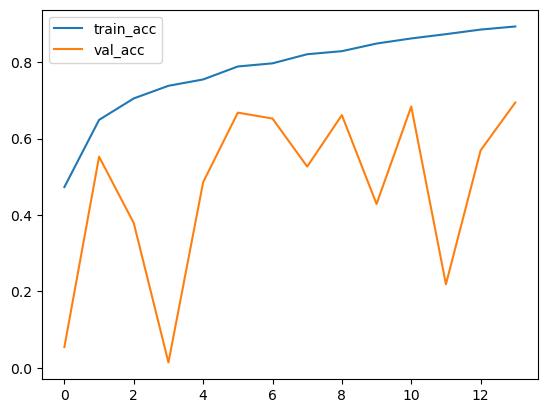

In [ ]:
# Path to metadata and images
data_csv = 'C:/Users/USER/Projects/Skin_classification/HAM10000_metadata.csv'
image_dir = 'C:/Users/USER/images'
data = pd.read_csv(data_csv)
data['image_id'] = data['image_id'] + '.jpg'
data['dx'] = data['dx'].astype(str)

train_df, val_df = train_test_split(data, stratify=data['dx'], test_size=0.2, random_state=42)

img_size = 224
batch_size = 32

datagen = ImageDataGenerator(rescale=1./255, horizontal_flip=True, rotation_range=10)
train_gen = datagen.flow_from_dataframe(train_df, image_dir, x_col='image_id', y_col='dx', target_size=(img_size, img_size), class_mode='categorical', batch_size=batch_size)
val_gen = datagen.flow_from_dataframe(val_df, image_dir, x_col='image_id', y_col='dx', target_size=(img_size, img_size), class_mode='categorical', batch_size=batch_size)

base_model = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(img_size, img_size, 3))
x = GlobalAveragePooling2D()(base_model.output)
x = Dense(128, activation='relu')(x)
output = Dense(len(train_gen.class_indices), activation='softmax')(x)
model = Model(inputs=base_model.input, outputs=output)

model.compile(optimizer=Adam(1e-4), loss='categorical_crossentropy', metrics=['accuracy'])

# Compute class weights
class_weights_array = compute_class_weight('balanced', classes=np.unique(train_df['dx']), y=train_df['dx'])
class_weights = dict(enumerate(class_weights_array))

callbacks = [
    EarlyStopping(patience=5, restore_best_weights=True),
    ModelCheckpoint('model_epoch_{epoch:02d}.keras', save_best_only=False)
]

history = model.fit(train_gen, validation_data=val_gen, epochs=20, callbacks=callbacks, class_weight=class_weights)

plt.plot(history.history['accuracy'], label='train_acc')
plt.plot(history.history['val_accuracy'], label='val_acc')
plt.legend()
plt.show()

model.save('skin_lesion_classifier_balanced.h5')





Plot training and validation metrics

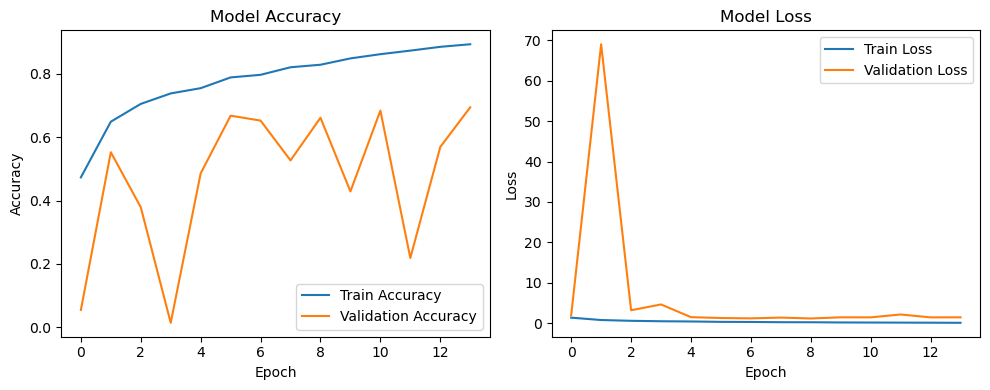

In [ ]:
# Plot Accuracy
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Plot Loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()


prediction on new image

In [ ]:
# Load the saved model
model = tf.keras.models.load_model('skin_lesion_classifier_balanced.h5')

# Specify the image path
img_path = 'C:/Users/USER/Projects/Skin_classification/SkinC3.jpg'
# Preprocess and predict
img = load_img(img_path, target_size=(224, 224))
img_array = img_to_array(img)
img_array = np.expand_dims(img_array, axis=0) / 255.

pred = model.predict(img_array)
predicted_class = np.argmax(pred)
confidence = np.max(pred)

if confidence > 0.6:
    print(f"Cancer detected. Tpye: {predicted_class} with high confidence. Please see a doctor for confirmation.")
else:
    print("No cancer detected. Please consult a doctor if you notice anything suspicious.")

#Conclusion
This deep learning project involved training a multi-class image classification model on a dataset of 10,015 validated images spanning 7 distinct classes. Leveraging transfer learning with EfficientNet and Keras' training pipeline, the model demonstrated strong learning capacity on the training set, reaching an accuracy of ~88% by epoch 14.

While the training performance improved steadily, the model exhibited varying validation accuracy and loss, likely due to class imbalance, noisy labels, or overfitting. Despite these challenges, the experiment offers valuable insights into model optimization, the impact of validation strategies, and the importance of regularization techniques.

Going forward, I plan to:

Introduce more robust data augmentation and class weighting

Fine-tune learning rates and regularization methods

Evaluate using test-time augmentation (TTA) and ensemble methods

This project has been a hands-on reinforcement of key deep learning concepts and workflow—from data preprocessing to model training and evaluation. It lays the groundwork for future improvements and deployment-ready image classification pipelines.